In [40]:
import pandas as pd
import numpy as np
from gower import gower_matrix
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [34]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
n_samples = 100

# Create age groups with some patterns
age = np.concatenate([
    np.random.normal(25, 3, 30),  # Young group
    np.random.normal(40, 5, 40),  # Middle age group
    np.random.normal(60, 4, 30)   # Senior group
]).round()

# Create income patterns correlated with age
base_income = age * 1000
noise = np.random.normal(0, 10000, n_samples)
income = base_income + noise

# Create education levels with patterns
education_probs = {
    'HS': 0.3,
    'BS': 0.4,
    'MS': 0.2,
    'PhD': 0.1
}
education = np.random.choice(
    list(education_probs.keys()),
    size=n_samples,
    p=list(education_probs.values())
)

# Create job sectors with some correlation to education
job_sectors = []
for edu in education:
    if edu == 'PhD':
        sector = np.random.choice(['Research', 'Academia'], p=[0.6, 0.4])
    elif edu in ['MS', 'BS']:
        sector = np.random.choice(['Tech', 'Finance', 'Healthcare'], p=[0.4, 0.3, 0.3])
    else:
        sector = np.random.choice(['Service', 'Sales', 'Admin'], p=[0.4, 0.3, 0.3])
    job_sectors.append(sector)

# Create experience years correlated with age
experience = (age - 22 + np.random.normal(0, 2, n_samples)).round()
experience = np.maximum(experience, 0)  # No negative experience

# Create satisfaction scores
satisfaction = np.random.randint(1, 6, n_samples)  # 1-5 scale

# Combine into DataFrame
df = pd.DataFrame({
    'Age': age,
    'Income': income,
    'Education': education,
    'Job_Sector': job_sectors,
    'Experience': experience,
    'Satisfaction': satisfaction
})

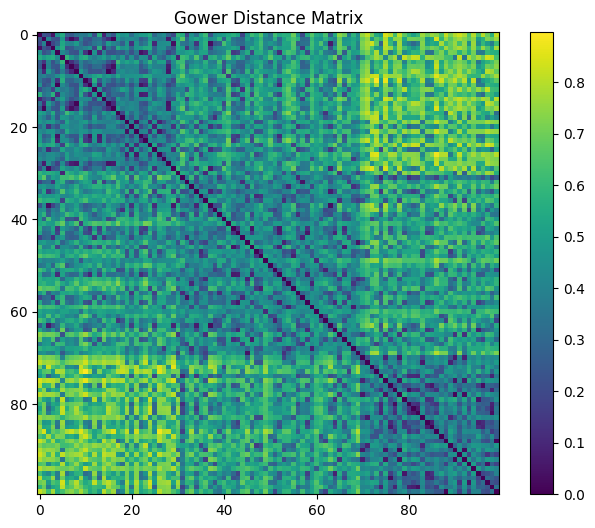

In [36]:
# Create boolean mask for categorical features
categorical_features = np.array([
    col in df.select_dtypes(include=['object', 'category']).columns 
    for col in df.columns
])

# Define weights as numpy array
weight = np.array([1.0] * len(df.columns))  # Equal weights for now

# Calculate Gower distance
gower_dist = gower_matrix(df, cat_features=categorical_features, weight=weight)

# Visualize
plt.figure(figsize=(8, 6))
plt.imshow(gower_dist)
plt.colorbar()
plt.title('Gower Distance Matrix')
plt.show()

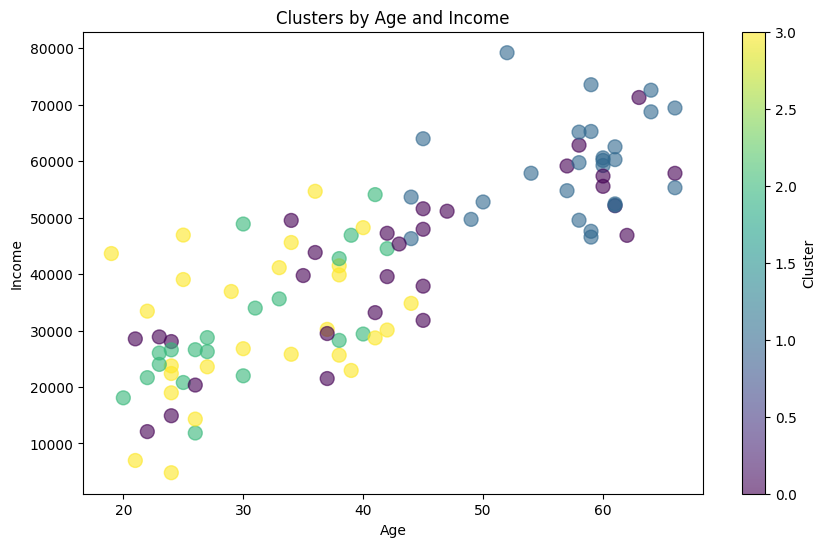

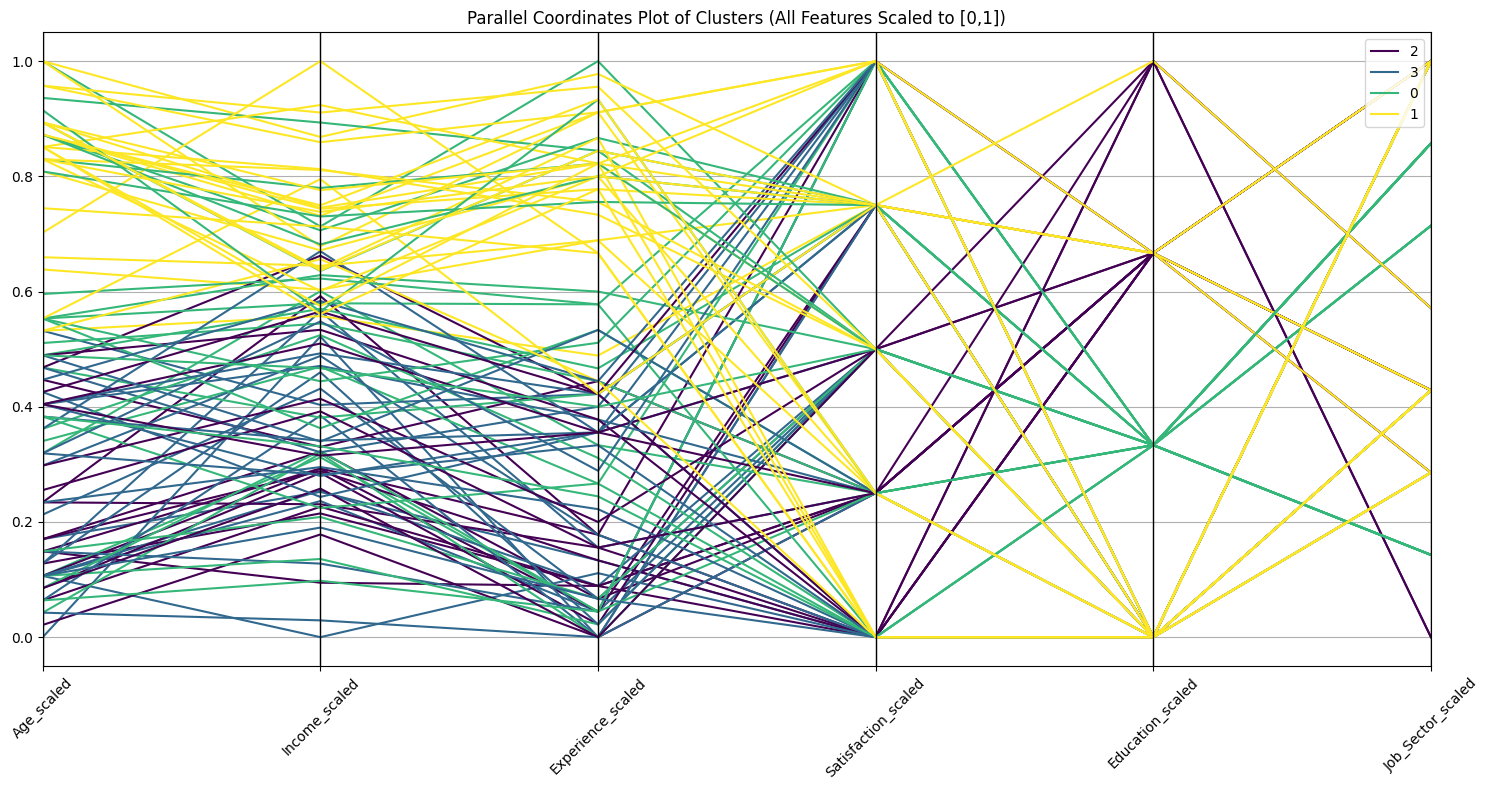

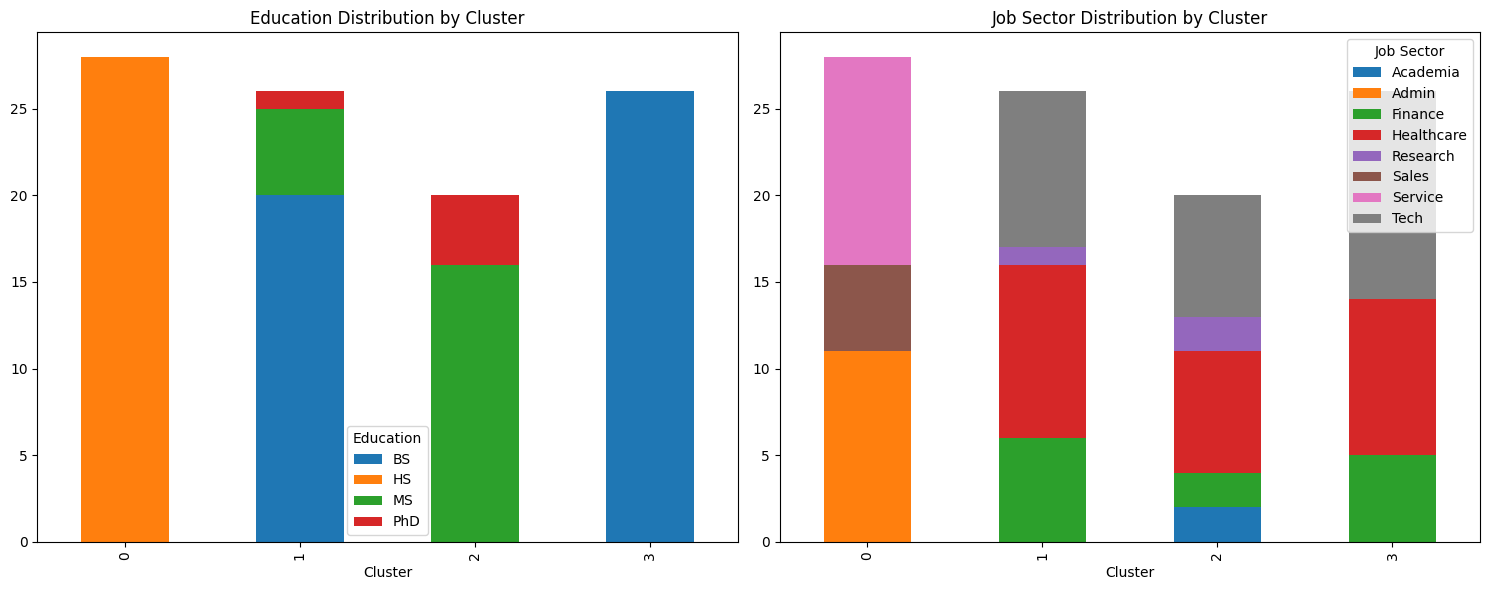


Cluster Summary:

Cluster 0:

Numerical Features:
             Age        Income  Experience  Satisfaction
count  28.000000     28.000000   28.000000     28.000000
mean   42.892857  41615.402894   20.964286      3.107143
std    13.947891  15053.512439   13.980097      1.314852
min    21.000000  12094.636749    0.000000      1.000000
25%    34.750000  29314.121502   11.750000      2.000000
50%    42.500000  44570.382845   20.500000      3.000000
75%    57.250000  51700.365991   34.500000      4.000000
max    66.000000  71271.832490   45.000000      5.000000

Categorical Features:
Education distribution:
Education
HS    28
Name: count, dtype: int64

Job Sector distribution:
Job_Sector
Service    12
Admin      11
Sales       5
Name: count, dtype: int64

Cluster 1:

Numerical Features:
             Age        Income  Experience  Satisfaction
count  26.000000     26.000000   26.000000     26.000000
mean   57.269231  59184.489473   34.807692      3.000000
std     6.315427   8809.963208    6

In [45]:
# Perform clustering
n_clusters = 4  # Increased number of clusters for more complex data
clustering = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='precomputed',
    linkage='complete'
)
clusters = clustering.fit_predict(gower_dist)

# Add clusters to dataframe
df['Cluster'] = clusters

# Visualizations

# 1. Scatter plot with age and income, colored by cluster
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['Age'], df['Income'], c=df['Cluster'], 
                     cmap='viridis', s=100, alpha=0.6)
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Clusters by Age and Income')
plt.colorbar(scatter, label='Cluster')
plt.show()

# 2. Prepare data for parallel coordinates plot
# Prepare data for parallel coordinates plot
df_plot = df.copy()

# 1. Encode categorical variables
le_edu = LabelEncoder()
le_job = LabelEncoder()
df_plot['Education_encoded'] = le_edu.fit_transform(df_plot['Education'])
df_plot['Job_Sector_encoded'] = le_job.fit_transform(df_plot['Job_Sector'])

# 2. Scale all features to [0,1] range
# Get numerical and encoded columns automatically
feature_cols = df_plot.columns[df_plot.columns.str.contains('encoded|Age|Income|Experience|Satisfaction')]
# Create scaled column names
scaled_cols = [f"{col.replace('_encoded', '')}_scaled" for col in feature_cols]
# Scale features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_plot[feature_cols])
# Create scaled DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=scaled_cols)
df_scaled['Cluster'] = df_plot['Cluster']

# Parallel coordinates plot with scaled features
plt.figure(figsize=(15, 8))
pd.plotting.parallel_coordinates(
    df_scaled,
    'Cluster',
    colormap=plt.cm.viridis
)
plt.title('Parallel Coordinates Plot of Clusters (All Features Scaled to [0,1])')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Cluster composition for categorical variables
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Education distribution
pd.crosstab(df['Cluster'], df['Education']).plot(
    kind='bar', ax=ax1, stacked=True)
ax1.set_title('Education Distribution by Cluster')
ax1.set_xlabel('Cluster')
ax1.legend(title='Education')

# Job Sector distribution
pd.crosstab(df['Cluster'], df['Job_Sector']).plot(
    kind='bar', ax=ax2, stacked=True)
ax2.set_title('Job Sector Distribution by Cluster')
ax2.set_xlabel('Cluster')
ax2.legend(title='Job Sector')

plt.tight_layout()
plt.show()

# 4. Summary statistics
print("\nCluster Summary:")
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    cluster_data = df[df['Cluster'] == cluster]
    print("\nNumerical Features:")
    print(cluster_data[['Age', 'Income', 'Experience', 'Satisfaction']].describe())
    print("\nCategorical Features:")
    print("Education distribution:")
    print(cluster_data['Education'].value_counts())
    print("\nJob Sector distribution:")
    print(cluster_data['Job_Sector'].value_counts())

In [ ]:
# Euclidean vs Mahattan Distance

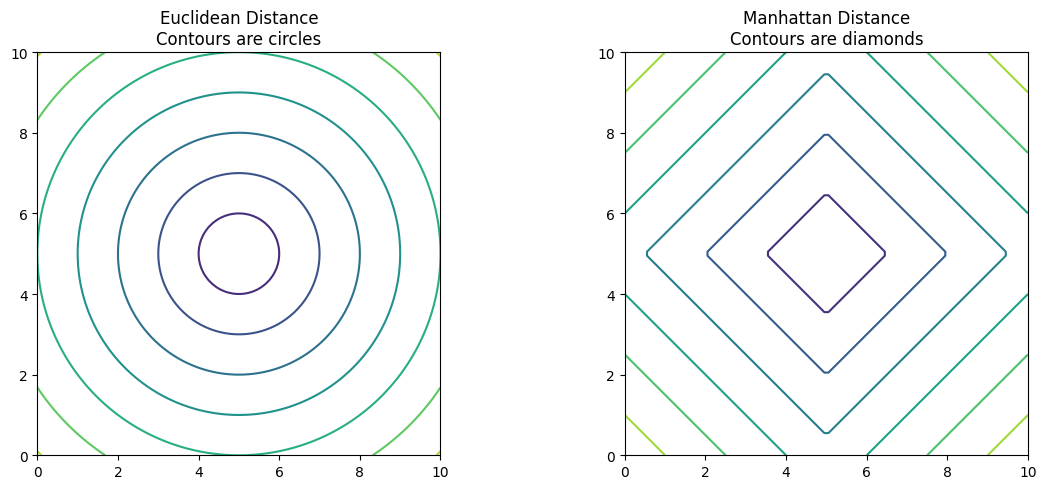

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Visualize difference between distances
def plot_distances():
    # Create points
    x = np.linspace(0, 10, 100)
    y = np.linspace(0, 10, 100)
    X, Y = np.meshgrid(x, y)
    point = [5, 5]
    
    # Calculate distances
    euclidean = np.sqrt((X - point[0])**2 + (Y - point[1])**2)
    manhattan = np.abs(X - point[0]) + np.abs(Y - point[1])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot contours
    ax1.contour(X, Y, euclidean)
    ax1.set_title('Euclidean Distance\nContours are circles')
    ax1.set_aspect('equal')
    
    ax2.contour(X, Y, manhattan)
    ax2.set_title('Manhattan Distance\nContours are diamonds')
    ax2.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

plot_distances()